In [1]:
# BLOQUE 1 — Cargar AOI

import geopandas as gpd

# Leer el geojson
aoi = gpd.read_file('../data/geojson/campo-bruzo.geojson')


In [2]:
# BLOQUE 2 — Mostrar AOI en mapa interactivo (más zoomado)

import geemap.foliumap as geemap
import json

# 1. Reproyectar AOI a Web-Mercator (3857) — lo que usan los mapas web
aoi_proj = aoi.to_crs(epsg=3857)

# 2. Centro en lat/lon (4326) para inicializar el mapa
center = [
    aoi_proj.to_crs(epsg=4326).geometry.centroid.y.mean(),
    aoi_proj.to_crs(epsg=4326).geometry.centroid.x.mean()
]

# 3. Crear mapa con zoom más cercano (por ej. 15)
m = geemap.Map(center=center, zoom=15)

geojson_dict = json.loads(aoi.to_json())
m.add_geojson(geojson_dict, layer_name='AOI')

bounds = aoi_proj.to_crs(epsg=4326).total_bounds  # [minx, miny, maxx, maxy]
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

# 6. Mostrar mapa
m


/Users/chrisijjas/Desktop/itba/satellite-image-processing/sat/lib/python3.13/site-packages/geemap/conversion.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/3530808338.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoi_proj.to_crs(epsg=4326).geometry.centroid.y.mean(),
/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/3530808338.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoi_proj.to_crs(epsg=432

In [4]:
# BLOQUE 3 — Descargar automáticamente la última imagen de Sentinel-2 y exportar TODAS las bandas necesarias

import geemap, ee
from datetime import date

# 1. Conectarse a Google Earth Engine (solo la primera vez pide el token)
ee.Authenticate()
ee.Initialize()

# 2. Convertir AOI (GeoDataFrame) a FeatureCollection / Geometry de GEE
aoi_fc   = geemap.geopandas_to_ee(aoi)
aoi_geom = aoi_fc.geometry()

# 3. Definir rango temporal: desde 2024-01-01 hasta HOY
today = date.today().strftime("%Y-%m-%d")

collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(aoi_geom)
    .filterDate("2024-01-01", today)
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5))   # ≤5 % nubes
    .sort("system:time_start", False)                     # más reciente primero
)

latest = collection.first()
print("Última imagen:", latest.date().format("YYYY-MM-dd").getInfo())

# 4. Bandas a exportar  (nombre → archivo de salida)
bands = {
    "B2" : "B2.tif",   # Blue
    "B3" : "B3.tif",   # Green
    "B4" : "B4.tif",   # Red
    "B5" : "B5.tif",   # Red-Edge 1 (705 nm)
    "B8" : "B8.tif",   # NIR 10 m
    "B8A": "B8A.tif",  # Red-Edge 4 / Narrow‐NIR (865 nm)
    "B11": "B11.tif",  # SWIR1
    "B12": "B12.tif",  # SWIR2
}

# 5. Resolución por banda (m).  GEE re-muestra automáticamente.
scale = {
    "B2": 10, "B3": 10, "B4": 10,
    "B5": 20,           # red-edge 20 m
    "B8": 10,
    "B8A": 20,  # red-edge 20 m
    "B11": 20, "B12": 20,
    
}

# 6. Exportar cada banda recortada al AOI
for b, out_name in bands.items():
    print(f"   ➜ exportando {b}  →  {out_name}  ({scale[b]} m)")
    geemap.ee_export_image(
        latest.select(b),
        filename=f"../data/sentinel2/{out_name}",
        scale=scale[b],
        region=aoi_geom
    )


Última imagen: 2025-06-01
   ➜ exportando B2  →  B2.tif  (10 m)
Generating URL ...
Please wait ...
Data downloaded to /Users/chrisijjas/Desktop/itba/satellite-image-processing/data/sentinel2/B2.tif
   ➜ exportando B3  →  B3.tif  (10 m)
Generating URL ...
Please wait ...
Data downloaded to /Users/chrisijjas/Desktop/itba/satellite-image-processing/data/sentinel2/B3.tif
   ➜ exportando B4  →  B4.tif  (10 m)
Generating URL ...
Please wait ...
Data downloaded to /Users/chrisijjas/Desktop/itba/satellite-image-processing/data/sentinel2/B4.tif
   ➜ exportando B5  →  B5.tif  (20 m)
Generating URL ...
Please wait ...
Data downloaded to /Users/chrisijjas/Desktop/itba/satellite-image-processing/data/sentinel2/B5.tif
   ➜ exportando B8  →  B8.tif  (10 m)
Generating URL ...
Please wait ...
Data downloaded to /Users/chrisijjas/Desktop/itba/satellite-image-processing/data/sentinel2/B8.tif
   ➜ exportando B8A  →  B8A.tif  (20 m)
Generating URL ...
Please wait ...
Data downloaded to /Users/chrisijjas/De

In [5]:
# BLOQUE 4 — Leer TODAS las bandas Sentinel-2 y recortarlas al AOI

import rasterio
import rasterio.mask
from shapely.geometry import mapping

# ---------- Función genérica ----------
def read_band_crop(path_band, aoi_gdf):
    """Lee un raster, reproyecta el AOI al CRS del raster y devuelve el array recortado + metadata."""
    with rasterio.open(path_band) as src:
        raster_crs = src.crs
        aoi_proj   = aoi_gdf.to_crs(raster_crs)                   # reproyectar AOI
        out_img, _ = rasterio.mask.mask(src,
                                        aoi_proj.geometry.apply(mapping),
                                        crop=True)
        return out_img[0], src.meta                               # sólo la 1.ª banda, metadata intacta

# ---------- Rutas a cada banda ----------
paths = {
    "B2" : "../data/sentinel2/B2.tif",   # Blue   (10 m)
    "B3" : "../data/sentinel2/B3.tif",   # Green  (10 m)
    "B4" : "../data/sentinel2/B4.tif",   # Red    (10 m)
    "B5" : "../data/sentinel2/B5.tif",   # Red-Edge 1 (20 m)
    "B8" : "../data/sentinel2/B8.tif",   # NIR    (10 m)
    "B8A": "../data/sentinel2/B8A.tif",  # Red-Edge 4 / Narrow NIR (20 m)
    "B11": "../data/sentinel2/B11.tif",  # SWIR1  (20 m)
    "B12": "../data/sentinel2/B12.tif",  # SWIR2  (20 m)
}

# ---------- Leer todas las bandas ----------
bands = {}
for bn, p in paths.items():
    arr, meta = read_band_crop(p, aoi)
    bands[bn] = arr.astype("float32")    # guardamos como float32 para cálculos posteriores

# Podemos tomar la metadata de una banda de 10 m (B4) como referencia para guardar resultados
meta_ref = meta

# Ejemplo de acceso:
blue_band  = bands["B2"]
green_band = bands["B3"]
red_band   = bands["B4"]
rededge_b5 = bands["B5"]
nir_band   = bands["B8"]
narrow_nir = bands["B8A"]
swir1      = bands["B11"]
swir2      = bands["B12"]

print("Bandas recortadas y listas:",
      ", ".join(bands.keys()))


Bandas recortadas y listas: B2, B3, B4, B5, B8, B8A, B11, B12


/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/531061714.py:5: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir_band - red_band) / (nir_band + red_band)


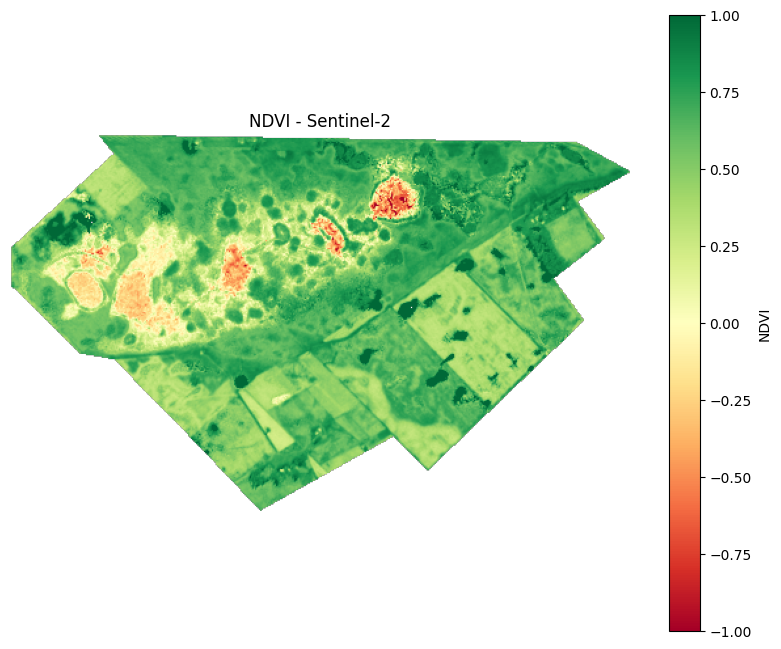

In [ ]:
from matplotlib import pyplot as plt
# BLOQUE 6A — Calcular NDVI, Mostrar NDVI
# Vegetación general (sanidad, biomasa)

ndvi = (nir_band - red_band) / (nir_band + red_band)

plt.figure(figsize=(10,8))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI - Sentinel-2')
plt.axis('off')
plt.show()


In [ ]:
# ─────────────────────────────────────────────────────────────
# BLOQUE 7 — NDVI timelapse video (ordenado, sin “wobble”, cache de frames)
# ─────────────────────────────────────────────────────────────
#
# ▸ Re-proyecta cada imagen al MISMO grid (10 m) ⇒ evita el “salto”
# ▸ Ordena de la más vieja → más nueva
# ▸ Convierte fechas a “15 MAY 2025”
# ▸ Omite frames ya existentes
# ▸ Genera MP4 con libx264 y lo muestra en la notebook
# ─────────────────────────────────────────────────────────────

from datetime import datetime
import numpy as np
import imageio.v3 as iio          # API moderna de imageio
import os
from matplotlib import pyplot as plt
from IPython.display import Video, display

# 1. Función NDVI con proyección fija (para que las matrices no bailen)
ref_proj = collection.first().select("B4").projection()   # CRS + resolución 10 m

def calc_ndvi_fixed(img):
    ndvi = img.normalizedDifference(["B8", "B4"]).rename("NDVI")
    # reproject: mismo grid (10 m) para TODAS las imágenes → sin wobble
    ndvi = ndvi.reproject(ref_proj)                       # 10 m porque ref_proj ya es 10 m
    return img.addBands(ndvi)

# 2. Colección NDVI ordenada (oldest → newest)
ndvi_collection = (
    collection
    .map(calc_ndvi_fixed)
    .sort("system:time_start", True)                      # ascendente = más antigua primero
)

# 3. Listas de imágenes y fechas
n_images = ndvi_collection.size().getInfo()
print(f"Total imágenes en la colección: {n_images}")

image_list = ndvi_collection.toList(n_images)

date_strings = ndvi_collection.aggregate_array("system:time_start").map(
    lambda t: ee.Date(t).format("YYYY-MM-dd")
).getInfo()

# Fechas bonitas, e.g. "15 MAY 2025"
dates = [
    datetime.strptime(ds, "%Y-%m-%d").strftime("%d %b %Y").upper()
    for ds in date_strings
]

# 4. Carpeta para frames
out_dir = "../output/ndvi_frames"
os.makedirs(out_dir, exist_ok=True)

frame_paths = []

# 5. Generar (o reutilizar) cada frame
for i in range(n_images):
    frame_path = f"{out_dir}/frame_{i:03d}.png"
    frame_paths.append(frame_path)

    if os.path.exists(frame_path):
        print(f"🟢 Frame {i+1}/{n_images} ({dates[i]}) ya existe → cache ok")
        continue

    print(f"⚙️  Generando frame {i+1}/{n_images} ({dates[i]}) …")

    img        = ee.Image(image_list.get(i))
    ndvi_band  = img.select("NDVI")

    # Extraer NDVI a numpy (10 m, AOI definido)
    ndvi_array = geemap.ee_to_numpy(
        ndvi_band,
        region=aoi_geom,
        scale=10     # misma resolución que ref_proj
    )

    # Graficar y guardar PNG
    fig, ax = plt.subplots(figsize=(8, 6))
    cax     = ax.imshow(ndvi_array.squeeze(), cmap="RdYlGn", vmin=-1, vmax=1)
    ax.set_title(f"NDVI – {dates[i]}")
    ax.axis("off")
    fig.colorbar(cax, ax=ax, label="NDVI")
    plt.savefig(frame_path, bbox_inches="tight")
    plt.close(fig)


Total imágenes en la colección: 55
⚙️  Generando frame 1/55 (23 JAN 2024) …
⚙️  Generando frame 2/55 (23 JAN 2024) …
⚙️  Generando frame 3/55 (28 JAN 2024) …
⚙️  Generando frame 4/55 (28 JAN 2024) …
⚙️  Generando frame 5/55 (28 MAR 2024) …
⚙️  Generando frame 6/55 (17 APR 2024) …
⚙️  Generando frame 7/55 (17 APR 2024) …
⚙️  Generando frame 8/55 (02 MAY 2024) …
⚙️  Generando frame 9/55 (02 MAY 2024) …
⚙️  Generando frame 10/55 (01 JUN 2024) …
⚙️  Generando frame 11/55 (11 JUL 2024) …
⚙️  Generando frame 12/55 (11 JUL 2024) …
⚙️  Generando frame 13/55 (26 JUL 2024) …
⚙️  Generando frame 14/55 (26 JUL 2024) …
⚙️  Generando frame 15/55 (25 AUG 2024) …
⚙️  Generando frame 16/55 (04 SEP 2024) …
⚙️  Generando frame 17/55 (04 SEP 2024) …
⚙️  Generando frame 18/55 (14 SEP 2024) …
⚙️  Generando frame 19/55 (14 SEP 2024) …
⚙️  Generando frame 20/55 (19 OCT 2024) …
⚙️  Generando frame 21/55 (19 OCT 2024) …
⚙️  Generando frame 22/55 (13 NOV 2024) …
⚙️  Generando frame 23/55 (13 NOV 2024) …
⚙️  Gene

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (641, 495) to (656, 496) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).



🔄 Ensamblando video…
✅ Video guardado en: ../output/ndvi_timelapse.mp4


In [26]:

# 6. Escribir video MP4 (libx264)
video_path = "../output/ndvi_timelapse.mp4"
print("\n🔄 Ensamblando video…")

frames = [iio.imread(fp) for fp in frame_paths]           # leer PNGs en orden
iio.imwrite(video_path, frames, fps=10, codec="libx264")   # fps=2 → 2 frames/s

print(f"✅ Video guardado en: {video_path}")

# 7. Mostrar video en la notebook
display(Video(video_path, embed=True))



🔄 Ensamblando video…


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (641, 495) to (656, 496) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✅ Video guardado en: ../output/ndvi_timelapse.mp4


In [27]:
# Supongamos que `ndvi_array` es el array 2-D (float32) de tu imagen ya extraída
# y que la resolución es de 10 m  × 10 m  ( = 100 m² por píxel)

import numpy as np

# 1. Mascara de vegetación sana
healthy_mask = ndvi_array > 0.4

# 2. Contar píxeles True
n_pixels = np.count_nonzero(healthy_mask)

# 3. Área por píxel (m²)  → 100 m² para 10 m
pixel_area_m2 = 10 * 10

# 4. Área total en km²
area_km2 = n_pixels * pixel_area_m2 / 1e6

print(f"Vegetación sana (>0.4): {area_km2:.2f} km²")


Vegetación sana (>0.4): 10.21 km²


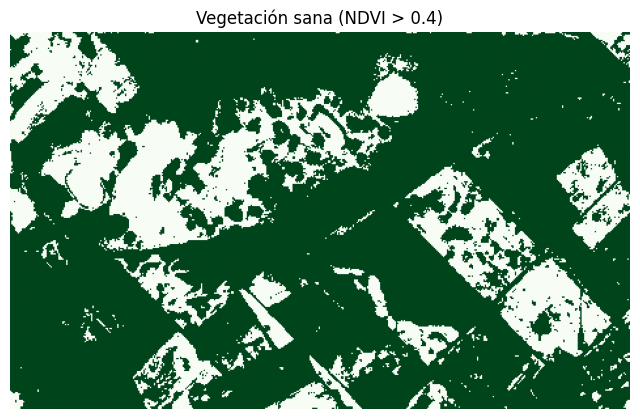

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.imshow(healthy_mask, cmap="Greens")
plt.title("Vegetación sana (NDVI > 0.4)")
plt.axis("off")
plt.show()


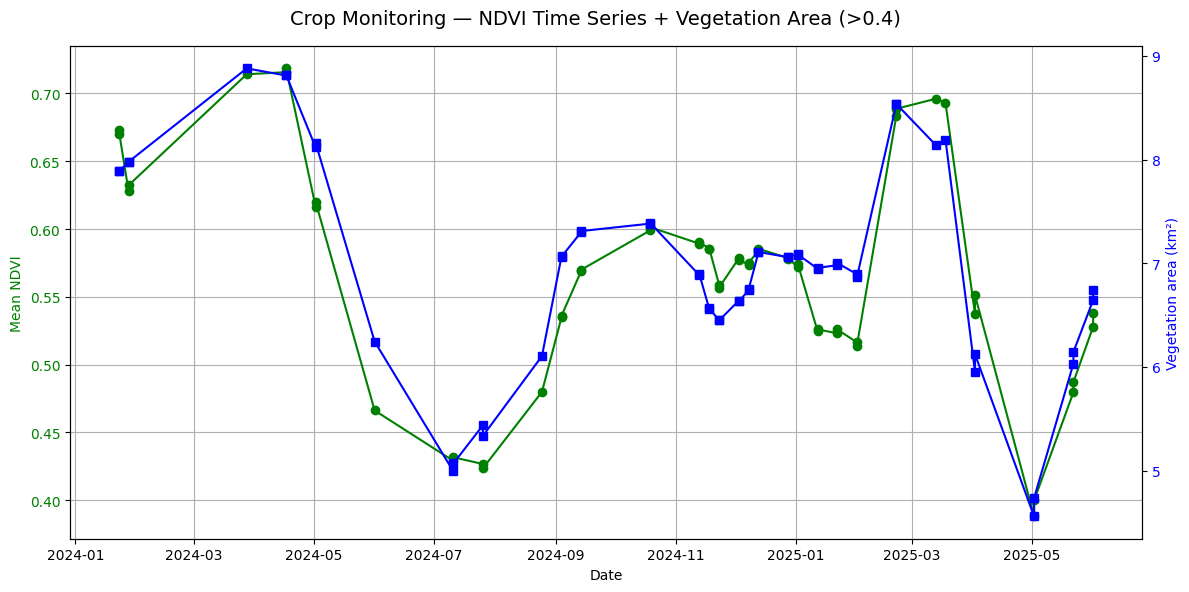

In [29]:
# BLOQUE 8 — Time series analysis: NDVI mean, NDVI>0.4 area, graphs

import pandas as pd
import matplotlib.pyplot as plt

# 1. NDVI function
def calc_ndvi(img):
    ndvi = img.normalizedDifference(["B8", "B4"]).rename("NDVI")
    return ndvi.copyProperties(img, ["system:time_start"])

# 2. NDVI collection ordered oldest→newest
ndvi_collection = (
    collection.map(calc_ndvi)
    .sort("system:time_start", True)   # ascending
)

# 3. Function to compute mean NDVI and area NDVI>0.4 per image
def stats_per_image(img):
    ndvi = img.select("NDVI")
    
    # Mean NDVI over AOI
    mean_dict = ndvi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi_geom,
        scale=10,
        maxPixels=1e13
    )
    
    # Area NDVI > 0.4
    ndvi_mask = ndvi.gt(0.4)
    pixel_area = ndvi_mask.multiply(ee.Image.pixelArea())
    
    area_dict = pixel_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi_geom,
        scale=10,
        maxPixels=1e13
    )
    
    # Return as Feature
    return ee.Feature(None, {
        'date': img.date().format('YYYY-MM-dd'),
        'mean_ndvi': mean_dict.get('NDVI'),
        'area_m2': area_dict.get('NDVI')
    })

# 4. Apply to collection
stats_fc = ndvi_collection.map(stats_per_image)
stats_list = stats_fc.getInfo()['features']

# 5. Convert to pandas DataFrame
df = pd.DataFrame([f['properties'] for f in stats_list])
df['date'] = pd.to_datetime(df['date'])
df['area_km2'] = df['area_m2'].astype(float) / 1e6
df['mean_ndvi'] = df['mean_ndvi'].astype(float)

# 6. Sort by date (important)
df = df.sort_values('date')

# 7. Plot time series — NDVI and area NDVI>0.4

fig, ax1 = plt.subplots(figsize=(12,6))

# Mean NDVI
ax1.plot(df['date'], df['mean_ndvi'], color='green', marker='o', label='Mean NDVI')
ax1.set_ylabel('Mean NDVI', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xlabel('Date')
ax1.grid(True)

# Area NDVI>0.4 on second axis
ax2 = ax1.twinx()
ax2.plot(df['date'], df['area_km2'], color='blue', marker='s', label='Area NDVI > 0.4 (km²)')
ax2.set_ylabel('Vegetation area (km²)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Titles and legend
fig.suptitle('Crop Monitoring — NDVI Time Series + Vegetation Area (>0.4)', fontsize=14)
fig.tight_layout()
plt.show()


# Explorando

/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/4115668954.py:3: RuntimeWarning: invalid value encountered in divide
  ndre = (narrow_nir - rededge_b5) / (narrow_nir + rededge_b5)


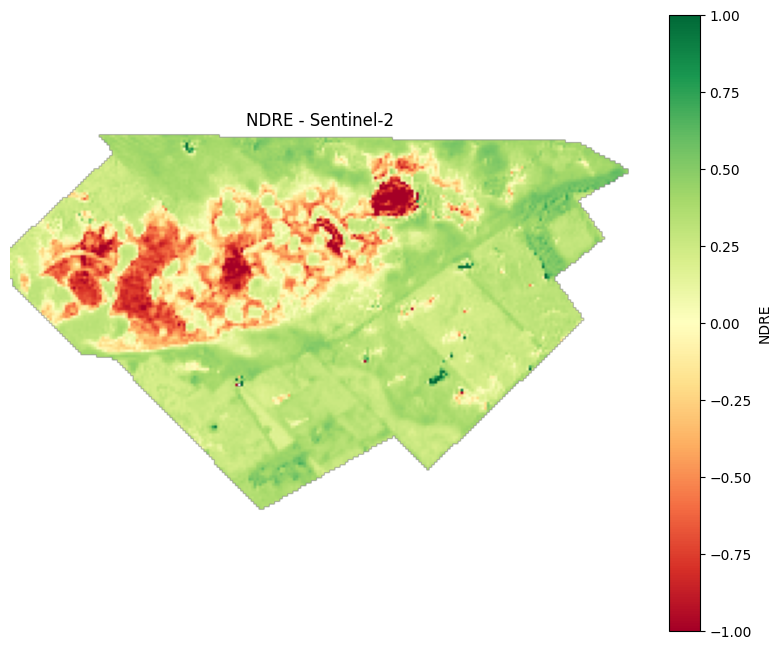

In [8]:
# BLOQUE 6B — Calcular NDRE, Mostrar NDRE
# Clorofila en cultivos densos (frutilla, repollo)
ndre = (narrow_nir - rededge_b5) / (narrow_nir + rededge_b5)

plt.figure(figsize=(10,8))
plt.imshow(ndre, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDRE')
plt.title('NDRE - Sentinel-2')
plt.axis('off')
plt.show()


/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/3298642917.py:4: RuntimeWarning: divide by zero encountered in divide
  cire = (narrow_nir / rededge_b5) - 1
/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/3298642917.py:4: RuntimeWarning: invalid value encountered in divide
  cire = (narrow_nir / rededge_b5) - 1


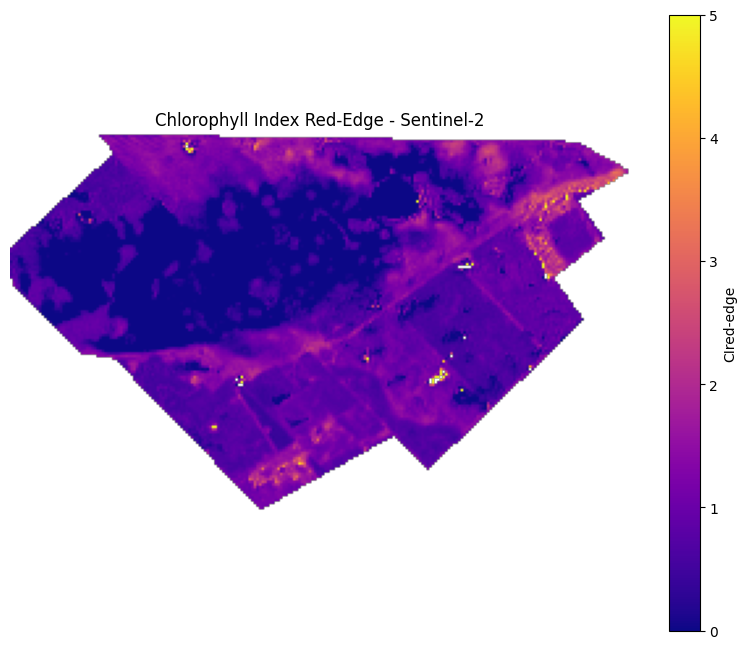

In [9]:
# BLOQUE 6C — Calcular CIred-edge, Mostrar CIred-edge
# Contenido de clorofila (diagnóstico nutricional)

cire = (narrow_nir / rededge_b5) - 1

plt.figure(figsize=(10,8))
plt.imshow(cire, cmap='plasma', vmin=0, vmax=5)
plt.colorbar(label='CIred-edge')
plt.title('Chlorophyll Index Red-Edge - Sentinel-2')
plt.axis('off')
plt.show()


/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/1249998680.py:7: RuntimeWarning: invalid value encountered in divide
  ndwi = (nir_band - swir1_resampled) / (nir_band + swir1_resampled)


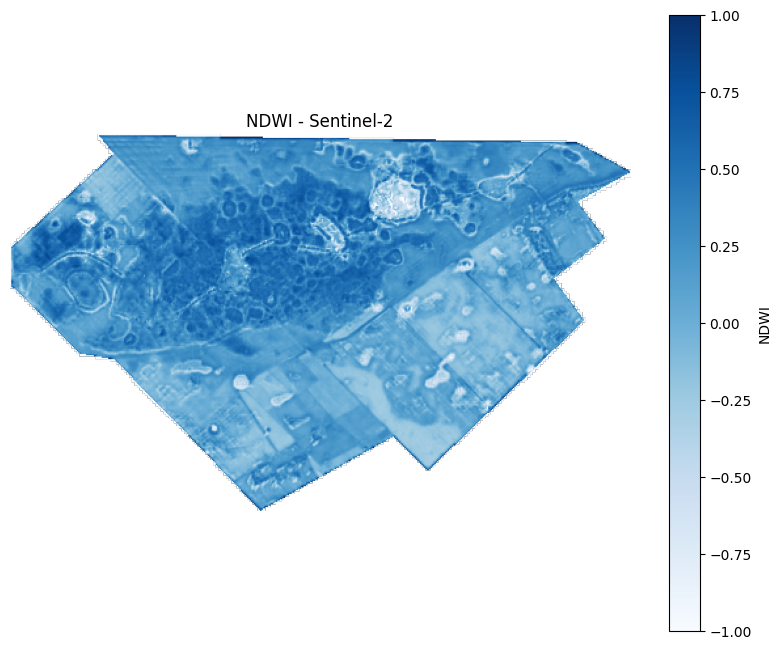

In [10]:
# BLOQUE 6D — Calcular NDWI, Mostrar NDWI (con resize rápido)

from skimage.transform import resize

swir1_resampled = resize(swir1, nir_band.shape, preserve_range=True)

ndwi = (nir_band - swir1_resampled) / (nir_band + swir1_resampled)

plt.figure(figsize=(10,8))
plt.imshow(ndwi, cmap='Blues', vmin=-1, vmax=1)
plt.colorbar(label='NDWI')
plt.title('NDWI - Sentinel-2')
plt.axis('off')
plt.show()


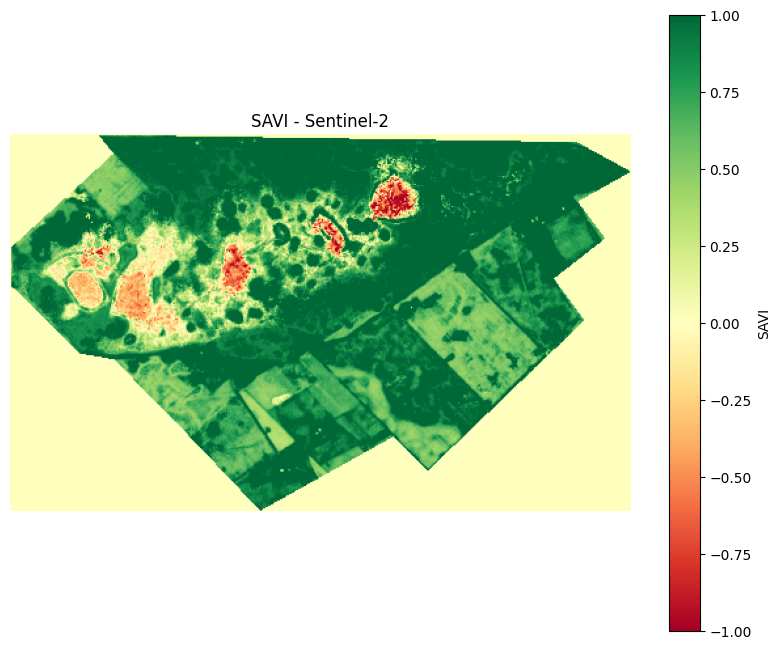

In [11]:
# BLOQUE 6E — Calcular SAVI, Mostrar SAVI
# Vegetación en estadios tempranos (mucho suelo visible)
savi = (1.5 * (nir_band - red_band)) / (nir_band + red_band + 0.5)

plt.figure(figsize=(10,8))
plt.imshow(savi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='SAVI')
plt.title('SAVI - Sentinel-2')
plt.axis('off')
plt.show()


/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/914114995.py:3: RuntimeWarning: divide by zero encountered in divide
  psri = (red_band - green_band) / nir_band
/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/914114995.py:3: RuntimeWarning: invalid value encountered in divide
  psri = (red_band - green_band) / nir_band


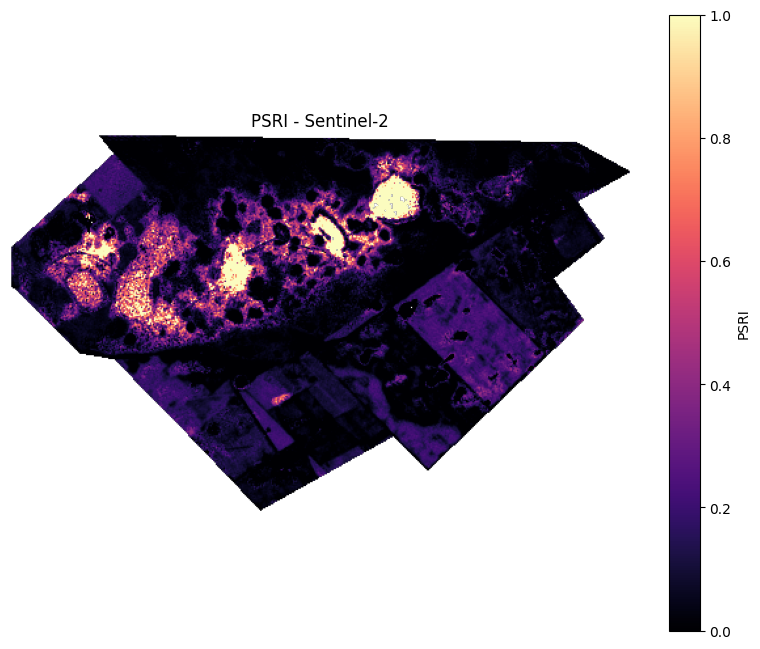

In [12]:
# BLOQUE 6F — Calcular PSRI, Mostrar PSRI
# Senescencia, maduración, inicio de cosecha
psri = (red_band - green_band) / nir_band

plt.figure(figsize=(10,8))
plt.imshow(psri, cmap='magma', vmin=0, vmax=1)
plt.colorbar(label='PSRI')
plt.title('PSRI - Sentinel-2')
plt.axis('off')
plt.show()
